

# Generating cluster samples

- Start with a cluster likelihood to produce a sample of clusters with mass and redshift.
- Generate _potentially_ observables: $\lambda$, $M_{\rm{WL}}$, $z_{\rm{obs}}$, ...
- Apply selection function, in terms of $\lambda$ and $z_{\rm{obs}}$
- The result is our observed cluster sample


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hmf

import torch

from sbi.analysis import pairplot
from sbi.inference import simulate_for_sbi
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

import pyccl as ccl

/pbs/home/c/cmurray/.conda/envs/sbi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


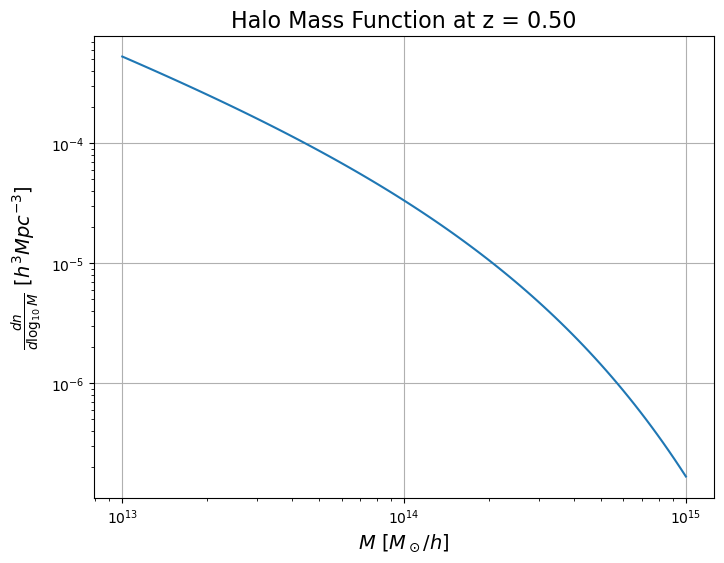

In [50]:

# Specify the cosmological parameters
cosmo_params = {
    'Omega_c': 0.27,  # Cold dark matter density fraction
    'Omega_b': 0.045, # Baryonic matter density fraction
    'h': 0.67,        # Hubble constant divided by 100
    'n_s': 0.96,      # Spectral index of the primordial power spectrum
    'sigma8': 0.8,    # Normalization of the power spectrum
    'Omega_k': 0.0    # Curvature parameter (assumed flat)
}

# Create a CCL Cosmology object
cosmo = ccl.Cosmology(**cosmo_params)

# Define redshift and mass range
z = 0.5  # Example redshift
masses = np.logspace(13, 15, 100)  # Mass range from 1e10 to 1e15 Msun/h

# Initialize the halo mass function object
hmf = ccl.halos.MassFuncTinker10( mass_def='200m' )

# Calculate the mass function (dn/dlog10M) at redshift z
dndlog10M = hmf( cosmo, masses, 1/(1+z) )

# Plot the halo mass function
plt.figure(figsize=(8, 6))
plt.loglog(masses, dndlog10M)
plt.xlabel(r'$M \ [M_\odot/h]$', fontsize=14)
plt.ylabel(r'$\frac{dn}{d\log_{10}M} \ [h^3 Mpc^{-3}]$', fontsize=14)
plt.title('Halo Mass Function at z = {:.2f}'.format(z), fontsize=16)
plt.grid(True)
plt.show()


In [49]:
cosmo.comoving_volume( 1/2 )

167740392269.87573

In [51]:
# create a grid of number counts

cluster_abundance = []

z_bins = np.arange( 0 , 1.2 , 0.05 )

# Specify the cosmological parameters
cosmo_params = {
    'Omega_c': 0.25,  # Cold dark matter density fraction
    'Omega_b': 0.05, # Baryonic matter density fraction
    'h': 0.7,        # Hubble constant divided by 100
    'n_s': 0.96,      # Spectral index of the primordial power spectrum
    'sigma8': 0.8,    # Normalization of the power spectrum
    'Omega_k': 0.0    # Curvature parameter (assumed flat)
}

# Create a CCL Cosmology object
cosmo = ccl.Cosmology(**cosmo_params)

# Define redshift and mass range
z = 0.5  # Example redshift
masses = np.logspace(13, 16.5, 100)  # Mass range from 1e10 to 1e15 Msun/h
dlog10m = np.log10( masses[1] ) -np.log10( masses[0] )

# Initialize the halo mass function object
hmf = ccl.halos.MassFuncTinker10( mass_def='200m' )

for i in np.arange( 1 , len( z_bins )):
    
    dOmega = 0.5 * 4 * np.pi
    dV = cosmo.comoving_volume( 1/ ( z_bins[i]+1) ) - cosmo.comoving_volume( 1/ ( z_bins[i-1]+1) )

    # Calculate the mass function (dn/dlog10M) at redshift z
    dndlog10M = hmf( cosmo, masses, 1/(1+ ( z_bins[i] + z_bins[i-1] )/2.)  )


    counts_per_bin = np.random.poisson( dndlog10M * dV * dOmega * dlog10m )
    cluster_abundance.append( counts_per_bin )
    
cluster_abundance = np.array( cluster_abundance )

In [52]:
cluster_abundance.shape

(23, 100)

In [53]:
np.sum( cluster_abundance )

220181441

In [54]:
log10ms = np.log10( masses )
zs = ( z_bins[1:] + z_bins[:-1] )/2.

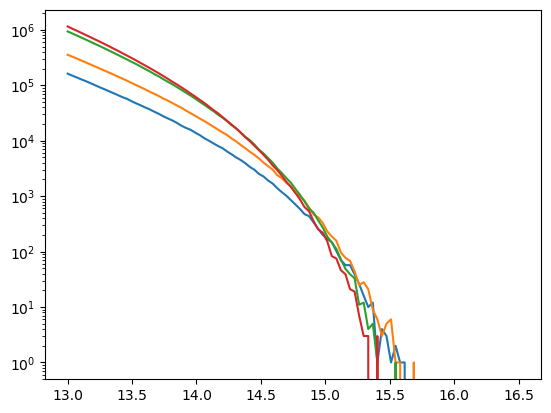

In [55]:
plt.plot( log10ms , cluster_abundance[3] )
plt.plot( log10ms , cluster_abundance[5] )
plt.plot( log10ms , cluster_abundance[10] )
plt.plot( log10ms , cluster_abundance[12] )
plt.yscale('log')
print()

In [52]:
# create a mass and redshift cluster catalogue 

# Flatten the cluster_abundance array
cluster_abundance_flat = cluster_abundance.flatten()

# Create a grid of mass and redshift values
mass_grid, redshift_grid = np.meshgrid( log10ms , zs )

# Flatten the mass and redshift grids
mass_values = mass_grid.flatten()
redshift_values = redshift_grid.flatten()

# Use np.repeat to create the catalog based on counts in cluster_abundance
cat_mass = np.repeat( mass_values, cluster_abundance_flat)
cat_redshift = np.repeat( redshift_values, cluster_abundance_flat)
cat_mu = np.log( 10**cat_mass / 1e14 )

In [71]:
test= ccl.halos.MassFuncDespali16( mass_def='200m' )

In [ ]:
test()

In [72]:
class Universe_simulation:
    
    def __init__( self, summary_statistic , for_simulate_for_sbi = False , log10Mmin = 13.5):
        """
        Initialize the Simulation class.
        """
        if summary_statistic == 'stacked_counts':
            self.summary_statistic = self.stacked_counts
        elif summary_statistic == 'unbinned_counts':
            self.summary_statistic = self.unbinned_counts
        else:
            print('Your chosen summary statistic is unknown:' , summary_statistic )
        self.selection_richness = 20
        self.for_simulate_for_sbi = for_simulate_for_sbi
        # hmf properties
        self.dlog10m = 0.01
        self.log10ms = np.arange( log10Mmin , 15.5 , self.dlog10m )
        self.Ms = 10**self.log10ms
        self.hmf = ccl.halos.MassFuncTinker10( mass_def='200m' )
        # Create a grid of mass and redshift values
        self.z_bins = np.arange( 0 , 1.2 , 0.05 )
        self.zs = ( self.z_bins[1:] + self.z_bins[:-1] )/2.
        mass_grid, redshift_grid = np.meshgrid( self.log10ms , self.zs )
        self.mass_grid = mass_grid
        self.redshift_grid = redshift_grid
        # Flatten the mass and redshift grids
        self.mass_values = self.mass_grid.flatten()
        self.redshift_values = self.redshift_grid.flatten()
        # for the stacked counts
        self.richness_bins = np.logspace( np.log10( 20 ), np.log10( 300 ), 15 )
        self.redshift_bins = np.linspace( 0.025 , 1.125 , 6 ) 
        # for the "unbinned" counts
        self.small_log10Mwl_bins = np.arange( 13. , 15.5 , 0.1 )
        self.small_richness_bins = np.logspace( np.log10( 20 ), np.log10( 300 ), 15 )
        self.small_redshift_bins = np.linspace( 0.025 , 1.125 , 6 ) 
        # survey size
        self.dOmega = 0.1 * 4*np.pi
        # fixed parameters
        self.alpha_mwl = 1
        self.sigma_mwl = 0.3 
        self.c_mwl = np.log( 1e14 )
        self.r = 0
        self.H0 = 70
        # transfer function
        #self.transfer_function = 'eisenstein_hu'
        self.transfer_function = 'boltzmann_camb'
        

    def run_simulation( self, parameter_set ):
        """
        Run the simulation with the given parameters.
        """
        richness, log10M_wl, z_clusters = self._run_simulation( parameter_set )
        
        if self.for_simulate_for_sbi:
            return torch.tensor( self.summary_statistic( richness, log10M_wl, z_clusters ) )
        else:
            return self.summary_statistic( richness, log10M_wl, z_clusters )
    

    def _run_simulation( self, parameter_set ):
        """
        Run the simulation. This contains the selection function!
        """
        
        # get the latent cluster properties, a poisson realisation
        mu_clusters, z_clusters = self.get_cluster_catalogue( parameter_set )
        
        # get the observed cluster properties
        richness, log10M_wl = self.mass_observable_relation(mu_clusters, z_clusters , parameter_set )
        
        # apply selection function
        selection = richness > self.selection_richness
        return richness[selection], log10M_wl[selection], z_clusters[selection], np.log10( np.exp( mu_clusters[selection] ) * 1e14 )
        

    def get_cluster_catalogue(self, parameter_set):
        Om0, sigma8, alpha_l, sigma_l, c_l = parameter_set

        # Ensure that parameters are native Python floats (not PyTorch tensors)
        Om0 = float(Om0)
        sigma8 = float(sigma8)

        # Create the CCL Cosmology object once
        cosmo = ccl.Cosmology(Omega_c = Om0 - 0.05,
                              Omega_b = 0.05,
                              h = self.H0 / 100,
                              n_s = 0.96,
                              sigma8 = sigma8,
                              Omega_k = 0.0,
                              transfer_function=self.transfer_function,
                              matter_power_spectrum='linear')

        dz = 0.05
        z_bins = np.arange( 0, 1.2, dz )
        z_bin_centers = (z_bins[:-1] + z_bins[1:]) / 2.0
        scale_factor_bins = 1/( z_bins + 1 )
        scale_factors = 1 / (z_bin_centers + 1)

        # Compute comoving volumes only once
        dV = cosmo.comoving_volume_element( scale_factors ) #cosmo.comoving_volume( scale_factor_bins[1:]) - cosmo.comoving_volume( scale_factor_bins[:-1] )
        da = scale_factor_bins[:-1] - scale_factor_bins[1:]
        
        cluster_abundance = []

        for i, a in enumerate(scale_factors):
            # Calculate halo mass function for the current redshift (as scalar `a`)
            dndlog10M = self.hmf( cosmo, self.Ms, a )

            # Compute counts in each bin
            counts_per_bin = np.random.poisson( dndlog10M * dV[i] * self.dlog10m * self.dOmega * da[i] )
            cluster_abundance.append(counts_per_bin)

        cluster_abundance = np.array(cluster_abundance).flatten()

        # Use np.repeat to create the catalog based on counts in cluster_abundance
        cat_mass = np.repeat(self.mass_values, cluster_abundance)
        cat_redshift = np.repeat(self.redshift_values, cluster_abundance)
        cat_mu = np.log( 10 ** cat_mass / 1e14 )

        return cat_mu, cat_redshift

    def mass_observable_relation( self, mu , z , parameter_set ):
        
        Om0, sigma8 , alpha_l , sigma_l , c_l =  parameter_set
        alpha_l = alpha_l.numpy()
        sigma_l = sigma_l.numpy()
        c_l = c_l.numpy()

        mean_l = c_l + alpha_l * mu
        mean_mwl = self.c_mwl + self.alpha_mwl * mu

        cov = [ [ sigma_l**2 , self.r * self.sigma_mwl * sigma_l ] , 
                [ self.r * self.sigma_mwl * sigma_l , self.sigma_mwl**2 ] ]

        noise = np.random.multivariate_normal( [ 0 , 0 ] , cov = cov  , size = len( mu ) )

        ln_richness = mean_l + noise.T[0]
        lnM_wl = mean_mwl + noise.T[1]


        return np.exp( ln_richness  ) , np.log10( np.exp( lnM_wl ) )
    

    def unbinned_counts(self, richness, log10M_wl, z_clusters ):
        """
        Calculate the number of clusters in bins of cluster richness, redshift, and weak lensing mass.

        Parameters:
        - richness: array-like, cluster richness values
        - log10M_wl: array-like, log10 of weak lensing mass values
        - z_clusters: array-like, redshift values of the clusters
        - richness_bins: array-like, edges of the bins for richness
        - redshift_bins: array-like, edges of the bins for redshift
        - mass_bins: array-like, edges of the bins for weak lensing mass (log10)

        Returns:
        - counts: a 3D array of shape (len(richness_bins)-1, len(redshift_bins)-1, len(mass_bins)-1)
        """

        # Calculate histogram counts in 3D bins
        counts, edges = np.histogramdd(
            np.column_stack([ richness, 
                              z_clusters, 
                              log10M_wl ]),
            bins=[ self.small_richness_bins, 
                   self.small_redshift_bins, 
                   self.small_log10Mwl_bins ]
        )

        return counts.flatten()
    
    def stacked_counts( self , richness, log10M_wl, redshift ):
        """
        Calculate the number of clusters in bins of cluster richness and redshift,
        and calculate the mean cluster weak-lensing mass in these bins.

        Parameters:
        richness (array-like): Array of richness values.
        log10M_wl (array-like): Array of weak-lensing mass values (log10 scale).
        redshift (array-like): Array of redshift values.
        richness_bins (array-like): Bin edges for richness.
        redshift_bins (array-like): Bin edges for redshift.

        Returns:
        observed_cluster_abundance (2D array): Number of clusters in each bin.
        mean_log10M_wl (2D array): Mean log10 weak-lensing mass in each bin.
        """
        # Compute the 2D histogram for cluster counts
        observed_cluster_abundance, _, _ = np.histogram2d(
            richness, 
            redshift, 
            bins=[ self.richness_bins, self.redshift_bins]
        )

        # Compute the 2D histogram for the sum of log10M_wl
        sum_log10M_wl, _, _ = np.histogram2d(  richness, 
                                               redshift, 
                                               bins=[ self.richness_bins, self.redshift_bins], 
                                               weights=log10M_wl
        )

        # Calculate mean log10M_wl in each bin (avoid division by zero)
        with np.errstate(divide='ignore', invalid='ignore'):
            mean_log10M_wl = np.where( observed_cluster_abundance > 0, 
                                       sum_log10M_wl / observed_cluster_abundance, 
                                       -1 )

        return np.vstack( [ observed_cluster_abundance, mean_log10M_wl ] ).flatten()   

In [80]:
unbinned_simulator = Universe_simulation( 'unbinned_counts' , log10Mmin = 13. )
richness, log10M_wl , redshift, cat_mass = unbinned_simulator._run_simulation( torch.Tensor( [ 0.3 , 0.8 , 0.8 , 0.3 , 3 ] ) )
len( richness )

118901

In [81]:
unbinned_simulator = Universe_simulation( 'unbinned_counts' , log10Mmin = 13.5 )
richness, log10M_wl , redshift, cat_mass = unbinned_simulator._run_simulation( torch.Tensor( [ 0.3 , 0.8 , 0.8 , 0.3 , 3 ] ) )
len( richness )

118601

In [84]:
unbinned_simulator = Universe_simulation( 'unbinned_counts' , log10Mmin = 13. )
%timeit richness, log10M_wl , redshift, cat_mass = unbinned_simulator._run_simulation( torch.Tensor( [ 0.3 , 0.8 , 0.8 , 0.3 , 3 ] ) )


2.79 s ± 279 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
unbinned_simulator = Universe_simulation( 'unbinned_counts' , log10Mmin = 13.5 )
%timeit richness, log10M_wl , redshift, cat_mass = unbinned_simulator._run_simulation( torch.Tensor( [ 0.3 , 0.8 , 0.8 , 0.3 , 3 ] ) )


1.37 s ± 64.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [77]:
len( richness )

117952

In [65]:
unbinned_simulator.dOmega

1.2566370614359172

In [66]:
cosmo.comoving_volume_element( 1/5 )

889573554142.2618

In [67]:
richness, log10M_wl , redshift, cat_mass = unbinned_simulator._run_simulation( torch.Tensor( [ 0.3 , 0.8 , 0.8 , 0.3 , 3 ] ) )

In [68]:
len( richness )

118357

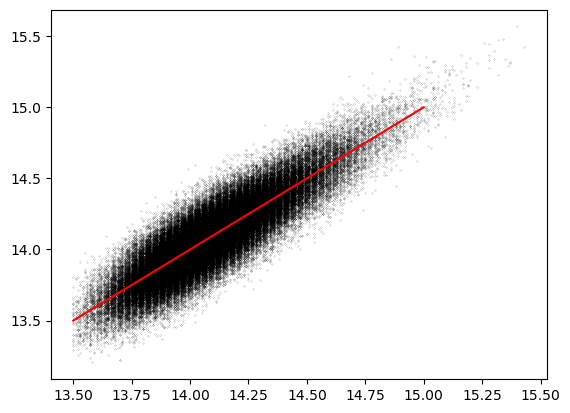

In [ ]:
plt.plot( cat_mass , log10M_wl , 'k.' , ms = 0.2 )
plt.plot( [ 13.5 , 15 ] , [ 13.5 , 15 ] , 'r-')
plt.show()

In [ ]:
plt.plot( richness , cat_mass , 'k.' , ms = 0.2 )
plt.xscale('log')

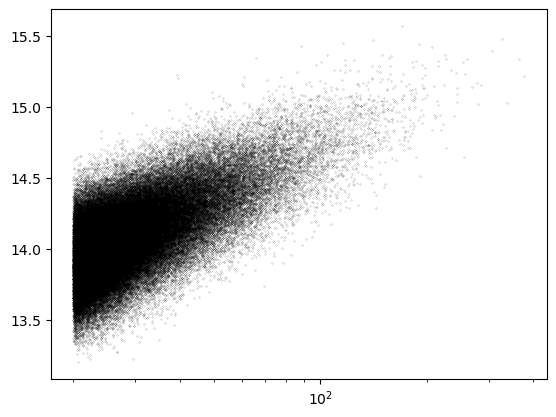

In [71]:
plt.plot( richness , log10M_wl , 'k.' , ms = 0.2 )
plt.xscale('log')

In [20]:
# Unbinned results is just our cluster catalogue
cluster_catalogue = np.vstack( [ richness[selected_clusters], log10M_wl[selected_clusters] , cat_redshift[selected_clusters] ] ).flatten()

In [21]:
def cluster_counts_measurement( richness, log10M_wl, redshift, richness_bins, redshift_bins):
    """
    Calculate the number of clusters in bins of cluster richness and redshift,
    and calculate the mean cluster weak-lensing mass in these bins.
    
    Parameters:
    richness (array-like): Array of richness values.
    log10M_wl (array-like): Array of weak-lensing mass values (log10 scale).
    redshift (array-like): Array of redshift values.
    richness_bins (array-like): Bin edges for richness.
    redshift_bins (array-like): Bin edges for redshift.
    
    Returns:
    observed_cluster_abundance (2D array): Number of clusters in each bin.
    mean_log10M_wl (2D array): Mean log10 weak-lensing mass in each bin.
    """
    # Compute the 2D histogram for cluster counts
    observed_cluster_abundance, _, _ = np.histogram2d(
        richness, 
        redshift, 
        bins=[richness_bins, redshift_bins]
    )
    
    # Compute the 2D histogram for the sum of log10M_wl
    sum_log10M_wl, _, _ = np.histogram2d(
        richness, 
        redshift, 
        bins=[richness_bins, redshift_bins], 
        weights=log10M_wl
    )
    
    # Calculate mean log10M_wl in each bin (avoid division by zero)
    with np.errstate(divide='ignore', invalid='ignore'):
        mean_log10M_wl = np.where( observed_cluster_abundance > 0, 
                                   sum_log10M_wl / observed_cluster_abundance, 
                                   np.nan )
    
    return observed_cluster_abundance, mean_log10M_wl

    
    

In [22]:
richness.min(), richness.max()

(6.7083758732613035, 281.32184780485784)

In [ ]:
cat_redshift.min(), cat_redshift.max()

In [23]:
richness_bins = np.logspace( np.log10( 20 ), np.log10( 300 ), 15 )
redshift_bins = np.linspace( 0.025 , 1.125 , 6 ) 

In [24]:
richness_cents = ( richness_bins[1:] + richness_bins[:-1] )/2.
redshift_cents = ( redshift_bins[1:] + redshift_bins[:-1] )/2.

In [25]:
observed_cluster_abundance, mean_log10M_wl = cluster_counts_measurement( richness[selected_clusters] , 
                                                                         log10M_wl[selected_clusters] , 
                                                                         cat_redshift[selected_clusters] , 
                                                                         richness_bins, 
                                                                         redshift_bins )

In [26]:
np.sum( observed_cluster_abundance )

100818.0

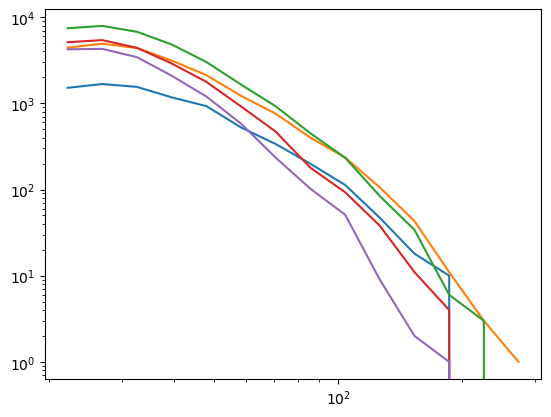

In [27]:
plt.plot( richness_cents , observed_cluster_abundance.T[0] )
plt.plot( richness_cents , observed_cluster_abundance.T[1] )
plt.plot( richness_cents , observed_cluster_abundance.T[2] )
plt.plot( richness_cents , observed_cluster_abundance.T[3] )
plt.plot( richness_cents , observed_cluster_abundance.T[4] )
plt.xscale('log')
plt.yscale('log')

In [28]:
mean_log10M_wl.shape

(14, 5)

Not the same as the mean relation due to the up-scatter I think.

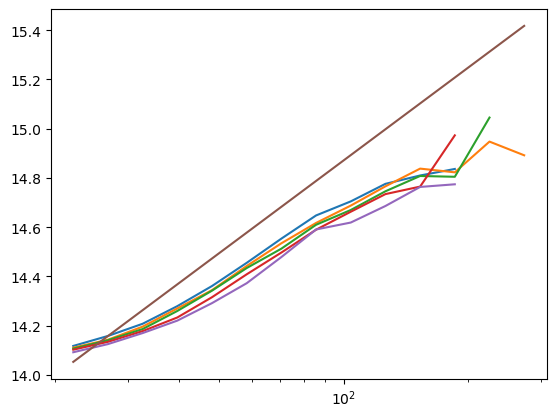

In [29]:
plt.plot( richness_cents , mean_log10M_wl.T[0] )
plt.plot( richness_cents , mean_log10M_wl.T[1] )
plt.plot( richness_cents , mean_log10M_wl.T[2] )
plt.plot( richness_cents , mean_log10M_wl.T[3] )
plt.plot( richness_cents , mean_log10M_wl.T[4] )
plt.plot( richness_cents , np.log10( 1e14 * np.exp( ( np.log( richness_cents ) - 3 ) / 0.8 ) ) )
plt.xscale('log')